In [1]:
import pandas as pd
from typing import Dict

In [2]:
img_df = pd.read_csv("/Users/adityajoshi/facebook_analysis/Train/Image/oxford.csv")
profile_df = pd.read_csv("/Users/adityajoshi/facebook_analysis/Train/Profile/Profile.csv")

In [3]:
img_df.head(n=1)

,userId,faceID,faceRectangle_width,faceRectangle_height,faceRectangle_left,faceRectangle_top,pupilLeft_x,pupilLeft_y,pupilRight_x,pupilRight_y,...,underLipTop_x,underLipTop_y,underLipBottom_x,underLipBottom_y,facialHair_mustache,facialHair_beard,facialHair_sideburns,headPose_roll,headPose_yaw,headPose_pitch
0,0000e06e07496624211632e8e264126c,f7e072db-8532-4686-9074-27e83fee5e94,61,61,15,49,32.7,64.7,59.7,65.0,...,41.8,94.3,41.9,98.6,0.0,0.0,0.0,3.9,-22.4,0.0


In [4]:
def extract_gender(df: pd.Series) -> int:
    return profile_df[profile_df["userid"] == df['userId']]["gender"].item()

In [5]:
genders = [extract_gender(row[1]) for row in img_df.iterrows()]

In [6]:
img_df = img_df.assign(gender=genders)

In [10]:
features, labels = img_df.drop(["userId", "faceID", "gender"], axis=1), img_df["gender"]

In [12]:
from sklearn.model_selection import validation_curve

In [23]:
from sklearn.ensemble import GradientBoostingClassifier
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt

In [30]:
Data = namedtuple("Data", ['X', 'y'])
NAVY = "#001f3f"


def experiment(estimator, preprocessed_train, hyper_parameter_name, hyper_parameter_values, x_axis_label):
    train_scores, valid_scores = validation_curve(estimator,
                                                  preprocessed_train.X,
                                                  preprocessed_train.y,
                                                  hyper_parameter_name,
                                                  hyper_parameter_values,
                                                  cv=4,
                                                  verbose=3,
                                                  n_jobs=3,
                                                  scoring="accuracy")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)
    plt.title("Validation Curve with xgboost for gender classification")
    plt.xlabel(x_axis_label)
    plt.ylabel("Accuracy")
    lw = 2

    plt.plot(hyper_parameter_values, train_scores_mean, label="Training Accuracy",
                 color="darkorange", lw=lw)
    plt.fill_between(hyper_parameter_values, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(hyper_parameter_values, valid_scores_mean, label="Cross-Validation Accuracy",
                 color=NAVY, lw=lw)
    plt.fill_between(hyper_parameter_values, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.2,
                     color=NAVY, lw=lw)
    print("Training Accuracy:", train_scores)
    print("Valid Accuracy:", valid_scores)
    plt.legend(loc="best")
    plt.show()

In [31]:
training_data = Data(X=features.values, y=labels.values)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   7 out of  24 | elapsed:    5.1s remaining:   12.4s
[Parallel(n_jobs=3)]: Done  16 out of  24 | elapsed:   14.3s remaining:    7.1s


Training Accuracy: [[0.86840775 0.8731469  0.8733367  0.8762001 ]
 [0.86908172 0.87348383 0.87434731 0.8762001 ]
 [0.87379949 0.87769542 0.8756948  0.88024255]
 [0.88104465 0.88258086 0.88310595 0.88512717]
 [0.88744735 0.89033019 0.89001179 0.89085397]
 [0.89283909 0.89487871 0.89506485 0.8967492 ]]
Valid Accuracy: [[0.88232323 0.86558868 0.87512639 0.86046512]
 [0.88181818 0.86508338 0.87563195 0.86097068]
 [0.88080808 0.86609399 0.87563195 0.86299292]
 [0.88131313 0.86255685 0.87411527 0.86046512]
 [0.88080808 0.86255685 0.87007078 0.85692619]
 [0.88131313 0.86205154 0.87007078 0.85793731]]


[Parallel(n_jobs=3)]: Done  24 out of  24 | elapsed:   24.8s finished


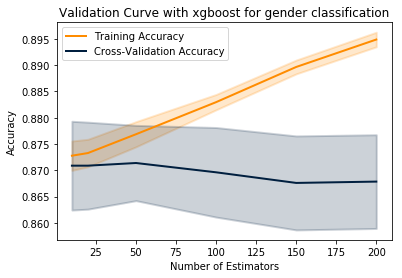

In [32]:
# Experiment 1: CV on Number of Boosting Stages.
from xgboost import XGBClassifier
experiment(XGBClassifier(max_depth=3, learning_rate=0.1),
           training_data,
           "n_estimators",
           [10, 20, 50, 100, 150, 200],
           "Number of Estimators")

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of  12 | elapsed:    2.4s remaining:    7.3s
[Parallel(n_jobs=3)]: Done   8 out of  12 | elapsed:    5.3s remaining:    2.7s


Training Accuracy: [[0.8673968  0.87230458 0.86929426 0.87451575]
 [0.87379949 0.87769542 0.8756948  0.88024255]
 [0.89772536 0.89706873 0.89472798 0.89826512]]
Valid Accuracy: [[0.88131313 0.86457807 0.87360971 0.85389282]
 [0.88080808 0.86609399 0.87563195 0.86299292]
 [0.88080808 0.86659929 0.87462083 0.85692619]]


[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:    8.1s finished


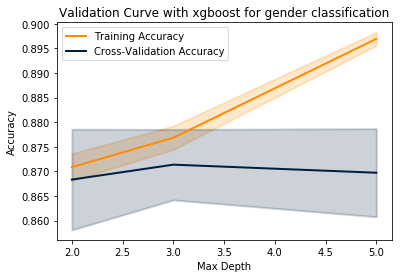

In [33]:
experiment(XGBClassifier(n_estimators=50),
           training_data,
           "max_depth",
           [2, 3, 5],
           "Max Depth")

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of  12 | elapsed:    1.6s remaining:    4.8s
[Parallel(n_jobs=3)]: Done   8 out of  12 | elapsed:    4.6s remaining:    2.3s


Training Accuracy: [[0.87379949 0.87769542 0.8756948  0.88024255]
 [0.86722831 0.87264151 0.87215766 0.87636854]
 [0.86655434 0.87264151 0.87215766 0.87653697]]
Valid Accuracy: [[0.88080808 0.86609399 0.87563195 0.86299292]
 [0.88181818 0.86407276 0.87563195 0.85995956]
 [0.88333333 0.86407276 0.87411527 0.86046512]]


[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:    6.4s finished


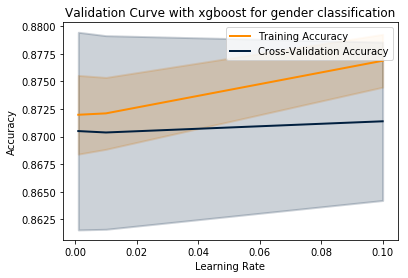

In [34]:
experiment(XGBClassifier(n_estimators=50, max_depth=3),
           training_data,
           "learning_rate",
           [0.1, 0.01, 0.001],
           "Learning Rate")